## Shapley Residual 公式推導

考慮有$d$個特徵的情形, $[d]\overset{\Delta}{=}\{1,2,3,...,d\}$, a coalition of features $S \in N \overset{\Delta}{=}2^{[d]}$.

原 value function $v$ 有對應的 differential operator: $\nabla v$. 
$$ \nabla: R^V \rightarrow R^E, \nabla v(S,S\cup \{i\})=v(S \cup \{i\})-v(S)$$


針對特徵$i$ 有 partial gradient: $\nabla_i v$.
$$
\nabla_i v(S, S \cup \{j\}) =  \begin{cases}
v(S \cup j) - v(S),  & i = j \\
0, & \text{otherwise}
\end{cases}
$$

計算 Shapley Residuals 需要先找出 $v_i$ 最接近 partial gradient $\nabla_i v$.

Solve $v_i = argmin_{X \in R^V} || \nabla X - \nabla_i v ||_2^2$

value function $X = \{x_0(=0), x_1, …, x_{n-1}\}$, where $n=2^d$.  $x_i$ represents both the value of the vertex and its associated fearture subset.

$$
\nabla X =
\begin{cases}
x_i - x_j,  & \text{if $x_i$ is adjunct to $x_j$ and comprises one more feature than $x_j$}  \\
0, & \text{otherwise}
\end{cases}
$$

將 $\nabla X$ 以矩陣形式（$A*X$）來表示，則$A$的維度應為 $m * n$, where $m=d*2^{d-1}$ (edges).

每一列(row) $A^k$ 代表一個 edge $e^k$ from $x_j$ to $x_i$

$$
A^k = 
\begin{cases}
a^k_i = 1,  a^k_j = -1,  & \text{if $x_i$ is adjunct to $x_j$ and comprises one more feature than $x_j$} \\
0, & \text{otherwise}
\end{cases}
$$

### ----- 解方程組 ---- 
若定義 $l = || A*X-Y ||^2_2$ , 求 $X$ 為何值時 $l$ 可取得最小值，其中 $A$ 為 $m*n$ 矩陣，$X$ 為 $n*1$ 向量， $Y$ 為 $m*1$ 向量。

由於我們定義 $x_0=0$, 故附加一列（row）$A^i=[1,0,...,0]$ 在$A$最後來求解，所以 $A$ 變為 $(m+1)*n$, $Y$ 變為 $(m+1)*1$ 向量 $[\nabla_i v, 0]$.

經全微分計算可得出 $X=((A^TA)^{-1}A^T)Y$， 我們可以先計算 $W=(A^T A)^{-1} A^T$，再代入 $W*Y$即可得到 $X$

本題中 $m$ 為 edge 數量, $n$ 為端點數。

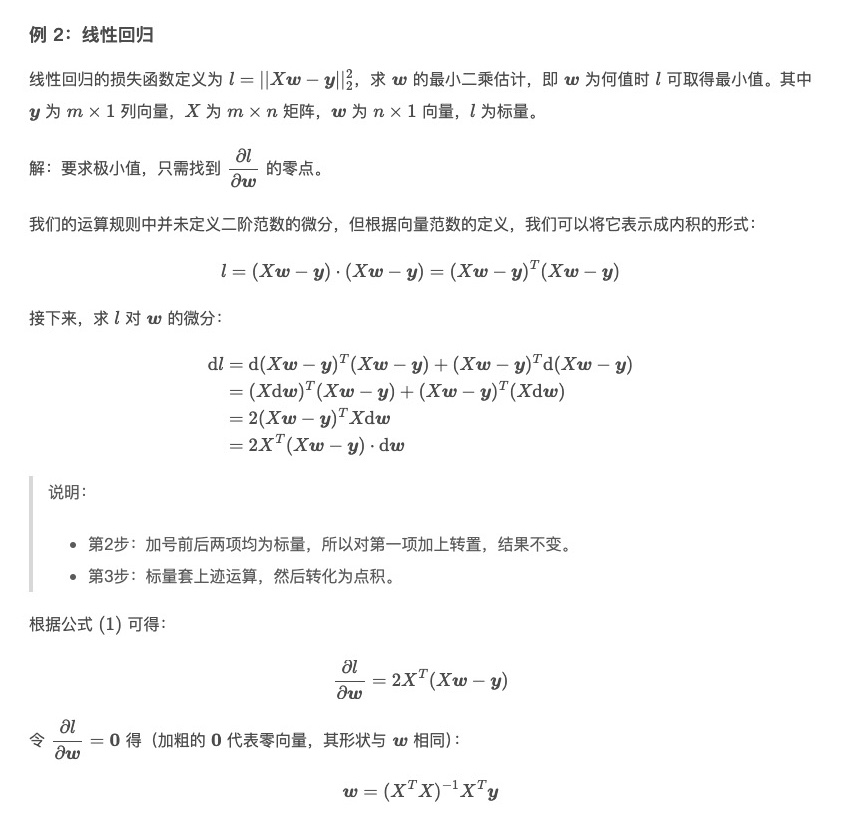

In [10]:
import numpy as np
import itertools
import bisect
from itertools import combinations

np.set_printoptions(precision=3, suppress=True)

def generate_all_subsets(num):
    num_set = [i for i in range(num)]
    all_subsets = [np.array(s) for r in range(num+1) for s in combinations(num_set, r) ]
    # Create a hash table to store the index of each subset
    subset_index_table = {}
    for index, value in enumerate(all_subsets):
        subset_index_table[tuple(value)] = index
    return all_subsets, subset_index_table, len(all_subsets)

class Hypercube:
    '''
    A class to create a hypercube object which stores values of vertices
    '''    
    #輸入維度
    def __init__(self, n_dim):   
        self.n_dim = n_dim
        # vertex_values is a dictionary to store the value of each vertex.
        # Because np.array is not hashable, we use tuple to represent the vertex.
        self.vertex_values = {}
        self.vertices, self.vertex_index, self.vertex_num = generate_all_subsets(n_dim)  #所有子集包含空集，即所有點
        self.edges, self.edge_num = self.build_edges()
        self.differential_matrix = None
        self.weight_matrix = None
        self.generate_min_l2_norm_matrix()
    
    def build_edges(self):
        full_elements = [i for i in range(self.n_dim)]
        full_set = set(full_elements)
        edges = []
        for r in range(self.n_dim):
            for v in combinations(full_elements, r):
                v_set = set(v)
                adjunct_v = full_set - v_set
                for new_elem in adjunct_v:
                    d_set = v_set | {new_elem}
                    edges.append((np.array(sorted(list(v_set))),np.array(sorted(list(d_set)))))
        return edges, len(edges)

    def set_vertex_values(self, vertex_values):         #設置點值
        for v in vertex_values:                         #用鍵值來做查找
            self.vertex_values[v] = vertex_values[v]
        
    def does_edge_exist(self, v1, v2):
        if abs(len(v1)-len(v2))==1:
            interset = np.intersect1d(v1,v2)
            smaller = v1 if len(v1)<len(v2) else v2
            return True if np.array_equal(smaller, interset) else False
        else:
            return False
    
    # Establish the matrix A in the above formula: AX-Y
    def generate_differential_matrix(self):
        if self.differential_matrix is None:
            self.differential_matrix = np.zeros((self.edge_num+1, self.vertex_num))
            for i,v_pair in enumerate(self.edges):
                j = self.vertex_index[tuple(v_pair[1])]
                k = self.vertex_index[tuple(v_pair[0])]
                self.differential_matrix[i][j] = 1
                self.differential_matrix[i][k] = -1
            # Add one more equestion that x_0 = 0 into the matrix form
            self.differential_matrix[-1][0]=1
        return self.differential_matrix

    # Pre-calcuate "W=(A^T*A)^-1*A^T" for the formula "X = ((A^T*A)^-1*A^T)*Y
    def generate_min_l2_norm_matrix(self):
        matrix_A = self.generate_differential_matrix()
        matrix_A_T = np.transpose(matrix_A)
        self.weight_matrix = np.linalg.inv(matrix_A_T @ matrix_A) @ matrix_A_T

    def get_gradient_vector(self):
        gradient_vector = np.zeros(self.edge_num)
        for i,v_pair in enumerate(self.edges):
            gradient_vector[i] = self.vertex_values[tuple(v_pair[1])]-self.vertex_values[tuple(v_pair[0])]    
        return gradient_vector
        
    def get_partial_gradient_vector(self,feature_i):
        partial_gradient_vector = np.zeros(self.edge_num)
        for i,v_pair in enumerate(self.edges):
            if (not feature_i in v_pair[0]) and (feature_i in v_pair[1]):
                partial_gradient_vector[i] = self.vertex_values[tuple(v_pair[1])]-self.vertex_values[tuple(v_pair[0])]    
        return partial_gradient_vector
    
    def resolve_vi(self, feature_i, phi_0=0):
        pd = self.get_partial_gradient_vector(feature_i)
        # Append equation x_0=0 at the end of partial gradient vector.
        pd = np.append(pd, phi_0)
        vi = self.weight_matrix @ pd
        # Reconstruct the vertex values
        new_vertices = {}
        for i,v in enumerate(self.vertices):
            new_vertices[tuple(v)] = vi[i]
        return vi, new_vertices

### 使用範例(Toy Example)

In [11]:
feature_i = 1

hyper = Hypercube(3)
vertices = {}
subsets, idx, _ = generate_all_subsets(3)

values = [0,1,0,0,1,1,2,3]
for v in subsets:
    vertices[tuple(v)] = values.pop(0)
hyper.set_vertex_values(vertices)

pd = hyper.get_partial_gradient_vector(feature_i)
print(f'partial gradient of feature {feature_i}:', pd)
vi, new_vs = hyper.resolve_vi(feature_i)
print(f'argmin vi:',vi)
print(new_vs)

h1 = Hypercube(3)
h1.set_vertex_values(new_vs)
dvi = h1.get_gradient_vector()
print('gradient of vi:',dvi)
print('residual:',dvi-pd)


partial gradient of feature 1: [0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 2. 0.]
argmin vi: [ 0.   0.   0.5 -0.5  0.5 -0.5  1.   1. ]
{(): 0.0, (0,): 4.440892098500626e-16, (1,): 0.5000000000000013, (2,): -0.5, (0, 1): 0.5000000000000004, (0, 2): -0.5, (1, 2): 1.0000000000000004, (0, 1, 2): 1.0000000000000004}
gradient of vi: [ 0.   0.5 -0.5  0.5 -0.5 -0.   0.5  0.   1.5  0.5  1.5  0. ]
residual: [ 0.   0.5 -0.5  0.5 -0.5 -0.   0.5  0.  -0.5  0.5 -0.5  0. ]


### 準備預測模型

In [13]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
s1_model_path = '/hcds_vol/private/luffy/GANGAN-master/model/predictor/stage_1_checkpoint.pth'
s1_model =  torch.load(s1_model_path, map_location=device).to(device)

In the beginning, target feature list and the translation map are constructed. After building the transition map, define the padding_zero function for the data translation of model usage.

In [16]:
import json
import numpy as np

json_file_path = '/hcds_vol/private/luffy/GANGAN-master/data/controllable_para_v014_14.json'
tool_name = 'ASCVD'
with open(json_file_path, 'r') as f:
    params = json.load(f)[tool_name]
    print(params)
    f.close()
target_features = []

''' 
    The feature_translation is a list of tuples, each tuple contains two integers.
    The tuples record the correponding position of the ith feature in the 4*freature matrix
    as the input the prediction model.
    Ex.
    [(0, 0), (0, 1), 
     (1, 2), (1, 3), 
     (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), 
     (3, 12),(3, 13)]
'''
# Flat the feature list and construct teh freature translation list to map feature into the input of the model
feature_translation = []
sub_op_num = 0
for entry in [sub_op for _, sub_op in params.items()]:
    if isinstance(entry, str):
        target_features.append(entry)
    else:
        target_features.extend(entry)
        feature_translation.extend([(sub_op_num,len(feature_translation)+j) for j in range(len(entry))])
        sub_op_num = sub_op_num+1 

print(target_features)
print(f"There are {sub_op_num} sub processes. So the feature translation is {feature_translation}")

def padding_zero(df, flag): 
    # 將一維參數matrix擴展為4維
    data_arr = df.to_numpy()
    result = []
    for data in data_arr:
        empty_arr = np.zeros((sub_op_num, len(feature_translation))) # chamber數 * 總參數數量
        for i, pos in enumerate(feature_translation):
            empty_arr[pos[0]][pos[1]] = data[i]
        if(flag == 1): # bert.py使用
            result.append(empty_arr)
        if(flag == 2): # bert_du.py使用
            result.append(empty_arr.tolist())
    
    if(flag == 1): # bert.py使用
        result = pd.DataFrame({'X': [result[i] for i in range(len(result))]})
    return result

{'EQ': ['X_-TACT_TIME_mean', 'X_-CONVEYOR_SPEED_mean'], 'PUMP': ['PUMP_high', 'PUMP_low'], 'CH': ['CLN1_over-etching-ratio', 'CLN1_EPT_time', 'clean_count', 'EPT_clean_count_ratio', 'NH3_TREAT_-RF_FREQ-max', 'NH3_TREAT_-RF_FREQ-range', 'NH3_TREAT_-RF_FREQ-mean', 'NP_3_-MFC_VOL_SIH4-range'], 'VENT': ['VENT_high', 'VENT_low'], 'y': 'DFT_CNT'}
['X_-TACT_TIME_mean', 'X_-CONVEYOR_SPEED_mean', 'PUMP_high', 'PUMP_low', 'CLN1_over-etching-ratio', 'CLN1_EPT_time', 'clean_count', 'EPT_clean_count_ratio', 'NH3_TREAT_-RF_FREQ-max', 'NH3_TREAT_-RF_FREQ-range', 'NH3_TREAT_-RF_FREQ-mean', 'NP_3_-MFC_VOL_SIH4-range', 'VENT_high', 'VENT_low', 'DFT_CNT']
There are 4 sub processes. So the feature translation is [(0, 0), (0, 1), (1, 2), (1, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (3, 12), (3, 13)]


### 隨機抽取樣本並儲存作為實驗數據

Randomly sample 1000 instances from the whole dataset for the experiment.

In [67]:
import os
import time
import pandas as pd
from datetime import datetime

csv_file_path = '/hcds_vol/private/luffy/GANGAN-master/data/processed_data/v014_stage_1.csv'
s1_df = pd.read_csv(csv_file_path)
# print(s1_df.shape)
filtered_df = s1_df[ (s1_df['PUMP_low']<20000) & (s1_df['PUMP_high']>20000) & (s1_df['VENT_low']<10000) & (s1_df['VENT_high']>10000) ]
#sample_df = filtered_df.sample(n=1000,random_state=42)
sample_df = filtered_df.sample(n=1000)[target_features]
experiment_name = 'sr_'+datetime.now().strftime("%Y%m%d%H%M")
sample_df.to_csv(f'./{experiment_name}.csv',index=False)
print(f'Experiment data {experiment_name}.csv with shape {sample_df.shape} is saved')
print(sample_df.columns)
print(sample_df.head())

Experiment data sr_202404261153.csv with shape (1000, 15) is saved
Index(['X_-TACT_TIME_mean', 'X_-CONVEYOR_SPEED_mean', 'PUMP_high', 'PUMP_low',
       'CLN1_over-etching-ratio', 'CLN1_EPT_time', 'clean_count',
       'EPT_clean_count_ratio', 'NH3_TREAT_-RF_FREQ-max',
       'NH3_TREAT_-RF_FREQ-range', 'NH3_TREAT_-RF_FREQ-mean',
       'NP_3_-MFC_VOL_SIH4-range', 'VENT_high', 'VENT_low', 'DFT_CNT'],
      dtype='object')
       X_-TACT_TIME_mean  X_-CONVEYOR_SPEED_mean    PUMP_high      PUMP_low  \
5379                 150                    3150  75666.00000  12465.320000   
34328                140                    2650  35883.38333   9189.166667   
28781                170                    3150  47919.06667  12198.960000   
30638                170                    3150  34231.45000  12465.320000   
23435                140                    2650  39607.90000   9688.575000   

       CLN1_over-etching-ratio  CLN1_EPT_time  clean_count  \
5379                  0.000300       

### 利用先前選取的實驗數據進行 Shapley Residual 分析

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

feature_df = pd.read_csv(f'./sr_202404261153.csv')
feature_df = feature_df.drop(columns=['DFT_CNT'])
# print(feature_df.head())
scaler = StandardScaler()
X_standardized = scaler.fit_transform(feature_df)
nf_df = pd.DataFrame(X_standardized)
print(nf_df.head())

         0         1         2         3         4         5         6   \
0 -0.287037 -0.024820  2.875640  0.685981 -1.103808 -1.494580 -0.810223   
1 -0.977030 -1.419203 -0.638191 -1.562440 -0.506616  0.162948 -1.303960   
2  1.092948 -0.024820  0.424870  0.503178 -0.845407  0.145708  2.152201   
3  1.092948 -0.024820 -0.784099  0.685981 -0.913335  0.143245 -0.810223   
4 -0.977030 -1.419203 -0.309220 -1.219697 -0.696299  1.005259 -0.810223   

         7         8         9         10        11        12        13  
0  0.018138  0.506778  0.385087  0.538751 -0.044766 -0.564172 -0.220484  
1  1.955741 -1.964448 -2.129546 -1.710621 -0.044766 -0.165713  0.460770  
2 -0.948180  0.561091  0.548467  0.895813 -0.044766  0.278097 -0.160092  
3  0.293459  0.459254  0.420604  0.843032 -0.044766  0.084338  0.237417  
4  0.438366  0.595036  0.541364  0.731076 -0.044766  1.563934  0.902867  


In [26]:
# unit test of padding_zero function
print(nf_df.head(1))
result = padding_zero(nf_df, 1)
print([e for e in result.iloc[0]])

         0        1        2         3         4        5         6   \
0 -0.287037 -0.02482  2.87564  0.685981 -1.103808 -1.49458 -0.810223   

         7         8         9         10        11        12        13  
0  0.018138  0.506778  0.385087  0.538751 -0.044766 -0.564172 -0.220484  
[array([[-0.287, -0.025,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  2.876,  0.686,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   , -1.104, -1.495, -0.81 ,  0.018,
         0.507,  0.385,  0.539, -0.045,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   , -0.564, -0.22 ]])]


In [17]:
# Convert dataframe(n,1) in which element 'X' contains 4*feature array into nparray (n,4,14)
nf_df_4d = padding_zero(nf_df,flag=1)
nf_df_4d_arr = np.array([e for entry in nf_df_4d.values for e in entry])
print(nf_df_4d_arr.shape)

(1000, 4, 14)


友達資料模型預測及平均

In [18]:
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
s1_model.eval()
nf_df_4d_tensor = torch.tensor(nf_df_4d_arr,dtype=torch.float)
dataset = TensorDataset(nf_df_4d_tensor)
batch_size = int(nf_df_4d_tensor.size()[0])
loader = DataLoader(dataset, batch_size=batch_size)
outputs = []
with torch.no_grad():
    for batch_data in loader:
        # 将数据移到指定的设备上（如 CUDA 设备）
        batch_data = batch_data[0].to(device)
        
        # 将数据传递给模型进行推理
        batch_output = s1_model(batch_data)
        probs = (torch.nn.functional.softmax(batch_output, dim=1))
        # 将输出保存起来
        outputs += probs
print(len(outputs), outputs)

1000 [tensor([0.4889, 0.5111]), tensor([0.4325, 0.5675]), tensor([0.6517, 0.3483]), tensor([0.3812, 0.6188]), tensor([0.8791, 0.1209]), tensor([0.8952, 0.1048]), tensor([0.4479, 0.5521]), tensor([0.6678, 0.3322]), tensor([0.7903, 0.2097]), tensor([0.7164, 0.2836]), tensor([0.4158, 0.5842]), tensor([0.6346, 0.3654]), tensor([0.5135, 0.4865]), tensor([0.9149, 0.0851]), tensor([0.5906, 0.4094]), tensor([0.7410, 0.2590]), tensor([0.9285, 0.0715]), tensor([0.7214, 0.2786]), tensor([0.8845, 0.1155]), tensor([0.2879, 0.7121]), tensor([0.8786, 0.1214]), tensor([0.4350, 0.5650]), tensor([0.9180, 0.0820]), tensor([0.7577, 0.2423]), tensor([0.7546, 0.2454]), tensor([0.5726, 0.4274]), tensor([0.7497, 0.2503]), tensor([0.7361, 0.2639]), tensor([0.8122, 0.1878]), tensor([0.9164, 0.0836]), tensor([0.7558, 0.2442]), tensor([0.8685, 0.1315]), tensor([0.6545, 0.3455]), tensor([0.8866, 0.1134]), tensor([0.9203, 0.0797]), tensor([0.7400, 0.2600]), tensor([0.1105, 0.8895]), tensor([0.3072, 0.6928]), tensor

取得模型平均和對應output

In [19]:
output_arr = np.array([output.cpu().numpy()[0] for output in outputs])
output_df = pd.DataFrame({'Output': output_arr})
new_df = pd.concat([feature_df,output_df],axis=1)


In [20]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

def model_inference(data,):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    scaler = StandardScaler()
    if 'Output' in data.columns:
        data = data.drop(columns=['Output'])
    data_standardized_df = pd.DataFrame(scaler.fit_transform(data))
    data_4d = padding_zero(data_standardized_df,flag=1)
    data_4d_array = np.array([e for entry in data_4d.values for e in entry])
    data_4d_tensor = torch.tensor(data_4d_array,dtype=torch.float)
    my_dataset = TensorDataset(data_4d_tensor)
    batch_size = min(256, int(data_4d_tensor.size()[0]))
    my_loader = DataLoader(my_dataset, batch_size=batch_size,num_workers=4)
    data_output = []
    with torch.no_grad():
        for batch_data in my_loader:
        # 将数据移到指定的设备上（如 CUDA 设备）
            batch_data = batch_data[0].to(device)
        # 将数据传递给模型进行推理
            batch_output = s1_model(batch_data)
            probs = (torch.nn.functional.softmax(batch_output, dim=1))
        # 将输出保存起来
            data_output += probs
    data_output_array = np.array([output.cpu().numpy()[0] for output in data_output])
    data_expectation_value = data_output_array.mean()
    return data_expectation_value, data_output_array

In [21]:
import numpy as np 
import warnings
import itertools
import pickle

# 過濾掉FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# First, calculate the output mean of the experiment data
base_mean, details = model_inference(feature_df)
print(f'Base mean: {base_mean}')

para_num = 14

AUO_coalitions, _, _ = generate_all_subsets(para_num) 
coalition_estimated_values = {}
instance = feature_df.iloc[0]
#mean_exp = new_df['Output'].mean()
count_n = 1
selected_data = feature_df.copy()

vertices_fl = 'E_vi_202404261153.pkl'
v_hist = vertices_fl.split('.')[0]+'_history.pkl'
try:
    with open(v_hist, 'rb') as f:
        print(f'Loading form {v_hist}...')
        v_history = pickle.load(f)
        print(type(v_history))
except FileNotFoundError:
    v_history = {}

# print(f"History vertices: {v_history}")

for coalition in AUO_coalitions:
    if tuple(coalition) in v_history:
        coalition_estimated_values[tuple(coalition)] = v_history[tuple(coalition)]
        continue
    vi_df = feature_df.copy()                   #用copy()才不會去更改到原始的dataframe
    if len(coalition)!=0:
        vi_df.iloc[:,coalition] = instance.iloc[coalition]
    exp, details = model_inference(vi_df)
    coalition_estimated_values[tuple(coalition)] =  exp - base_mean
    count_n += 1
    
    if count_n % 10 == 0:
        with open(vertices_fl, 'wb') as f:
            pickle.dump(coalition_estimated_values, f)
        print(f"Saved {count_n} vertices")

with open(vertices_fl, 'wb') as f:
    pickle.dump(coalition_estimated_values, f)


Base mean: 0.6319250464439392
Loading form E_vi_202404261153_history.pkl...
<class 'dict'>


In [21]:
print(coalition_estimated_values)

{(): 0.6319250464439392, (0,): 0.5956950187683105, (1,): 0.6195374727249146, (2,): 0.6205354928970337, (3,): 0.6224393248558044, (4,): 0.6332931518554688, (5,): 0.6594773530960083, (6,): 0.6476801633834839, (7,): 0.6400846838951111, (8,): 0.6157060861587524, (9,): 0.6147526502609253, (10,): 0.6236944794654846, (11,): 0.6316014528274536, (12,): 0.6240622401237488, (13,): 0.6358485817909241, (0, 1): 0.5644800066947937, (0, 2): 0.5864907503128052, (0, 3): 0.5796103477478027, (0, 4): 0.592803955078125, (0, 5): 0.6281248331069946, (0, 6): 0.6197041869163513, (0, 7): 0.5932244062423706, (0, 8): 0.5674665570259094, (0, 9): 0.5594530701637268, (0, 10): 0.5880378484725952, (0, 11): 0.5954770445823669, (0, 12): 0.5913259387016296, (0, 13): 0.5982637405395508, (1, 2): 0.6108293533325195, (1, 3): 0.6134511828422546, (1, 4): 0.6251241564750671, (1, 5): 0.6453974843025208, (1, 6): 0.6337630152702332, (1, 7): 0.6187399625778198, (1, 8): 0.6024383902549744, (1, 9): 0.5977538824081421, (1, 10): 0.61290

In [22]:
import copy

AUOcube = Hypercube(14)
h1 = copy.deepcopy(AUOcube)

In [23]:
# print(coalition_estimated_values)
AUOcube.set_vertex_values(coalition_estimated_values)

In [25]:
import copy

feature_i = 0

pd = AUOcube.get_partial_gradient_vector(feature_i)
# print(f'partial gradient of feature {feature_i}:', pd)
vi, new_vs = AUOcube.resolve_vi(feature_i)
print(f'argmin vi:',vi)
# print(new_vs)

h1.set_vertex_values(new_vs)
gvi = h1.get_gradient_vector()
print('gradient of vi:',gvi)

residual = gvi-pd
print('residual:',residual)

# Compute the norms of the individual arrays
norm_gvi = np.linalg.norm(gvi)
norm_pd = np.linalg.norm(pd)

norm_residual = np.linalg.norm(residual)
print(f"Scale norm of the residual for feature {feature_i}: {norm_residual/norm_gvi}")
# Compute the dot product
dot_product = np.dot(gvi, pd)

# Calculate the cosine similarity
cos_sim = dot_product / (norm_gvi * norm_pd)
print(norm_gvi)
print(norm_pd)

import math
print(f"Cosine Similarity between gvi and pd is {cos_sim*180/math.pi} degree")

argmin vi: [-0.    -0.05   0.005 ... -0.061  0.017 -0.067]
gradient of vi: [-0.05   0.005 -0.    ... -0.003 -0.007 -0.085]
residual: [-0.014  0.005 -0.    ... -0.003 -0.007  0.026]
Scale norm of the residual for feature 0: 0.26089267386224535
6.023987798039213
6.225624502684126
Cosine Similarity between gvi and pd is 55.44007296250192 degree


In [1]:
!nvidia-smi

Fri Mar 22 16:37:37 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  Off |
|  0%   45C    P8    19W / 480W |     17MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:07:00.0 Off |                  Off |
|  0%   